In [12]:
import sys
sys.path.append('../../../')

In [13]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [14]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

In [15]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [16]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_rmse_perc'
metric_filter_2 = 'val_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [17]:
sets_lengths = (0.3, 0.1, 0.6)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[100], [100] * 2, [100] * 3, [200], [200]*2,[200]*3,[500],[500]*2,[500]*3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=200,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
            scheduler_patience=20,
        )

100%|██████████| 54/54 [16:12<00:00, 18.00s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 1134/1134 [00:55<00:00, 20.25it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.47217798,
 'train_acc': 0.5658198595046997,
 'val_acc': 0.5972221493721008,
 'epoch': 120,
 'model_class': 'fnn',
 'path_name': '4_[100_100_100]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_120',
 'train_rmse': 0.7778694179672935,
 'val_rmse': 0.8207381501496754,
 'test_rmse': 0.8638584616435564,
 'train_rmse_perc': 0.18474239,
 'val_rmse_perc': 0.20527034,
 'test_rmse_perc': 0.2150988,
 'train_mcc': 0.42325361199267797,
 'val_mcc': 0.4572086352196384,
 'test_mcc': 0.46907929792604003,
 'test_acc': 0.5997692942619324}

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.47204483,
 'train_acc': 0.5658198595046997,
 'val_acc': 0.5972221493721008,
 'epoch': 150,
 'model_class': 'fnn',
 'path_name': '4_[100_100_100]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_150',
 'train_rmse': 0.7823101928744689,
 'val_rmse': 0.8207381501496754,
 'test_rmse': 0.8698460005026994,
 'train_rmse_perc': 0.18467923,
 'val_rmse_perc': 0.20516615,
 'test_rmse_perc': 0.21503495,
 'train_mcc': 0.42344654773301776,
 'val_mcc': 0.4572086352196384,
 'test_mcc': 0.46918812173565316,
 'test_acc': 0.5997692942619324}

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [200, 200, 200],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.451688,
 'train_acc': 0.5866050720214844,
 'val_acc': 0.6041666269302368,
 'epoch': 100,
 'model_class': 'fnn',
 'path_name': '4_[200_200_200]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_100',
 'train_rmse': 0.791116964050395,
 'val_rmse': 0.7772815877574012,
 'test_rmse': 0.8678547441698324,
 'train_rmse_perc': 0.18236464,
 'val_rmse_perc': 0.20154873,
 'test_rmse_perc': 0.21298128,
 'train_mcc': 0.4515047755456906,
 'val_mcc': 0.47990645972856927,
 'test_mcc': 0.43821417219732,
 'test_acc': 0.5790081024169922}

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1134/1134 [00:00<00:00, 15443.42it/s]


In [ ]:
cm = all[sort_idx[0]]['test_cm'][0]

In [ ]:
(cm.labels==0).sum()

tensor(230)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

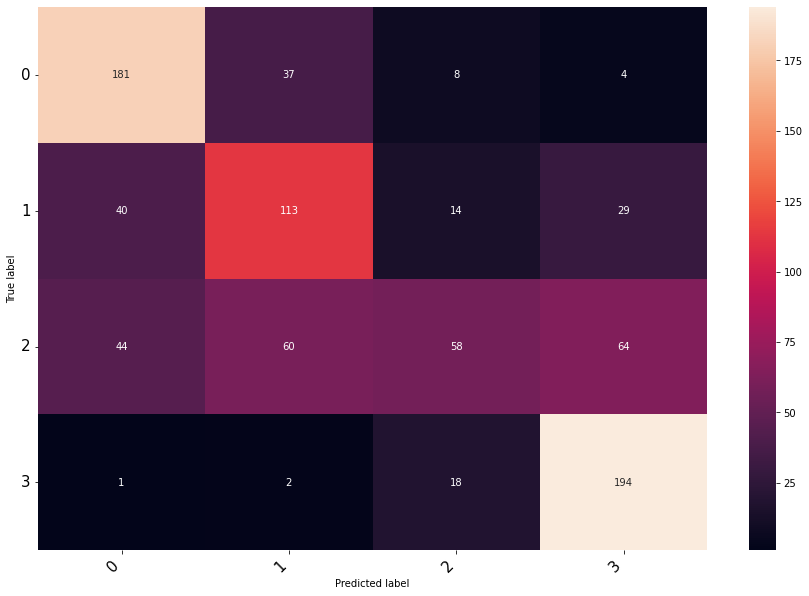

In [ ]:
cm.visualize()

In [ ]:
cm.class_accuracy

tensor([0.7870, 0.5765, 0.2566, 0.9023])

In [ ]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.17763509, 0.2611884, 0.27546555, 0.12878902]

In [ ]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.11359891, 0.18939438, 0.22494318, 0.09887825]

### GCN

In [ ]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [ ]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

In [ ]:
res_edges = res_edges_gcn
res_edges[0]

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

### GraphSAGE

In [18]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[500]*2], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0, 0.2],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0, 0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [19]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=2000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=50,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            scheduler_patience=300,
        )

100%|██████████| 4/4 [1:35:00<00:00, 1425.14s/it]


#### Results

In [20]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 164/164 [01:25<00:00,  1.93it/s]


True

In [21]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.27604866,
 'train_acc': 0.7505773901939392,
 'val_acc': 0.7083332538604736,
 'epoch': 1968,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2',
 'train_rmse': 0.5746773369208489,
 'val_rmse': 0.7728015412913086,
 'test_rmse': 0.8685190035431413,
 'train_rmse_perc': 0.15349157,
 'val_rmse_perc': 0.20799394,
 'test_rmse_perc': 0.22464536,
 'train_mae_perc': 0.11405533,
 'val_mae_perc': 0.14552853,
 'test_mae_perc': 0.16041073,
 'train_mcc': 0.6714308885824481,
 'val_mcc': 0.6095078248728703,
 '

In [22]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.27988493,
 'train_acc': 0.7690531015396118,
 'val_acc': 0.6388888359069824,
 'epoch': 1550,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1550',
 'train_rmse': 0.4947764092497898,
 'val_rmse': 0.7817359599705717,
 'test_rmse': 0.8263257845374696,
 'train_rmse_perc': 0.1296266,
 'val_rmse_perc': 0.20214592,
 'test_rmse_perc': 0.20788443,
 'train_mae_perc': 0.09869545,
 'val_mae_perc': 0.1433097,
 'test_mae_perc': 0.15014227,
 'train_mcc': 0.6926515651951118,
 'val_mcc': 0.5158146689404742,

In [23]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.3069464,
 'train_acc': 0.7875288724899292,
 'val_acc': 0.6944443583488464,
 'epoch': 1750,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1750',
 'train_rmse': 0.5108522065189811,
 'val_rmse': 0.6718548123582124,
 'test_rmse': 0.8705087404087495,
 'train_rmse_perc': 0.1406975,
 'val_rmse_perc': 0.17961036,
 'test_rmse_perc': 0.2176846,
 'train_mae_perc': 0.10441797,
 'val_mae_perc': 0.12630129,
 'test_mae_perc': 0.15531448,
 'train_mcc': 0.7170247913255614,
 'val_mcc': 0.5858190275959446,


In [24]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 164/164 [00:00<00:00, 3780.63it/s]


#### cm

In [25]:
cm = all[sort_idx[0]]['test_cm'][0]

In [26]:
(cm.labels==0).sum()

tensor(230)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

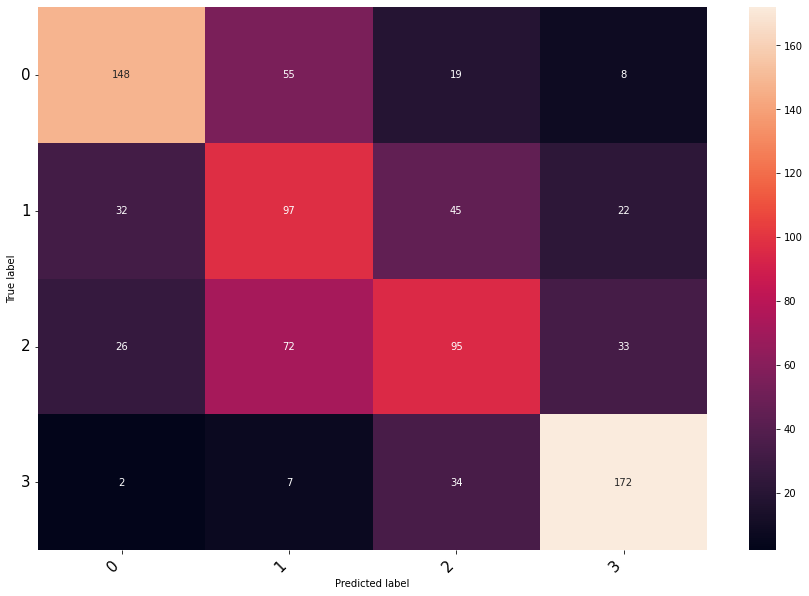

In [27]:
cm.visualize()

In [28]:
cm.class_accuracy

tensor([0.6435, 0.4949, 0.4204, 0.8000])

In [29]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.21662912, 0.23936318, 0.23892972, 0.16925511]

In [30]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.1413083, 0.1764855, 0.18269986, 0.12221124]

#### GraphSAGE Base_n

In [31]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[500]*2], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0, 0.2],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0, 0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [32]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=2000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=50,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            scheduler_patience=300,
            base_n=True,
        )

100%|██████████| 4/4 [1:30:53<00:00, 1363.29s/it]


##### Results

In [33]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 164/164 [01:09<00:00,  2.36it/s]


True

In [34]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.21427618,
 'train_acc': 0.6281754970550537,
 'val_acc': 0.555555522441864,
 'epoch': 400,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_400',
 'train_rmse': 0.6745111992900248,
 'val_rmse': 0.8457409637576849,
 'test_rmse': 0.8869163041489131,
 'train_rmse_perc': 0.15808997,
 'val_rmse_perc': 0.21233195,
 'test_rmse_perc': 0.2248482,
 'train_mae_perc': 0.12423627,
 'val_mae_perc': 0.1578848,
 'test_mae_perc': 0.16986792,
 'train_mcc': 0.5124856866982752,
 'val_mcc': 0.4125640106017029,
 '

In [35]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.33973664,
 'train_acc': 0.5219399333000183,
 'val_acc': 0.4166666269302368,
 'epoch': 750,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_750',
 'train_rmse': 0.7583256139156545,
 'val_rmse': 0.9090593428863095,
 'test_rmse': 0.8836591638622548,
 'train_rmse_perc': 0.17891987,
 'val_rmse_perc': 0.21606,
 'test_rmse_perc': 0.21869163,
 'train_mae_perc': 0.1458273,
 'val_mae_perc': 0.17586486,
 'test_mae_perc': 0.17367814,
 'train_mcc': 0.3717809487540418,
 'val_mcc': 0.2437485014886696,
 't

In [36]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.21427618,
 'train_acc': 0.6281754970550537,
 'val_acc': 0.555555522441864,
 'epoch': 400,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_400',
 'train_rmse': 0.6745111992900248,
 'val_rmse': 0.8457409637576849,
 'test_rmse': 0.8869163041489131,
 'train_rmse_perc': 0.15808997,
 'val_rmse_perc': 0.21233195,
 'test_rmse_perc': 0.2248482,
 'train_mae_perc': 0.12423627,
 'val_mae_perc': 0.1578848,
 'test_mae_perc': 0.16986792,
 'train_mcc': 0.5124856866982752,
 'val_mcc': 0.4125640106017029,
 '

In [37]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 164/164 [00:00<00:00, 1877.18it/s]


##### cm

In [38]:
cm = all[sort_idx[0]]['test_cm'][0]

In [39]:
(cm.labels==0).sum()

tensor(230)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

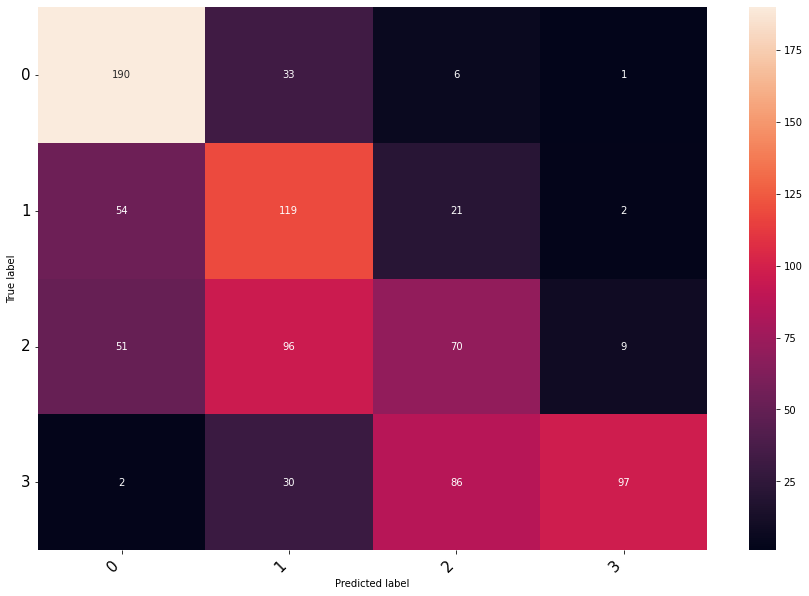

In [40]:
cm.visualize()

In [41]:
cm.class_accuracy

tensor([0.8261, 0.6071, 0.3097, 0.4512])

In [42]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.14406198, 0.1984843, 0.2822971, 0.24897322]

In [43]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.090367846, 0.15847053, 0.23582971, 0.19596817]

### GAT

In [44]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [45]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 288/288 [51:10<00:00, 10.66s/it]


#### Results

In [46]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 3168/3168 [03:41<00:00, 14.29it/s]


In [47]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [10],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': None,
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 3.0976212,
 'train_acc': 0.3094688355922699,
 'val_acc': 0.277777761220932,
 'epoch': 10,
 'model_class': 'gat',
 'path_name': '4_[10]_1_[4_4]_None_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0_10',
 'train_rmse': 1.6591825806787248,
 'val_rmse': 1.7480147469502525,
 'test_rmse': 1.6613525430211973,
 'train_rmse_perc': 0.5199949,
 'val_rmse_perc': 0.5434848,
 'test_rmse_perc': 0.5153711,
 'train_mae_perc': 0.44168591,
 'val_mae_perc': 0.4624306,
 'test_mae_perc': 0.42966554,
 'train_mcc': 0.11865251257943818,
 'val_

In [48]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.1572461,
 'train_acc': 0.23787528276443481,
 'val_acc': 0.277777761220932,
 'epoch': 40,
 'model_class': 'gat',
 'path_name': '4_[20]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2_40',
 'train_rmse': 1.0528746528633084,
 'val_rmse': 1.0573814617041266,
 'test_rmse': 1.066421540461737,
 'train_rmse_perc': 0.26294997,
 'val_rmse_perc': 0.27854162,
 'test_rmse_perc': 0.2729939,
 'train_mae_perc': 0.22720096,
 'val_mae_perc': 0.24259323,
 'test_mae_perc': 0.23749372,
 'train_mcc': -0.035618465104250464,

In [49]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.1482594,
 'train_acc': 0.23556582629680634,
 'val_acc': 0.2708333134651184,
 'epoch': 30,
 'model_class': 'gat',
 'path_name': '4_[20]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2_30',
 'train_rmse': 1.0539708266665655,
 'val_rmse': 1.050793351076541,
 'test_rmse': 1.0755755413256844,
 'train_rmse_perc': 0.26378858,
 'val_rmse_perc': 0.27775398,
 'test_rmse_perc': 0.27329272,
 'train_mae_perc': 0.22707711,
 'val_mae_perc': 0.24063164,
 'test_mae_perc': 0.2363663,
 'train_mcc': -0.03913923981637374,

In [50]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3168/3168 [00:00<00:00, 6470.77it/s]
